# Sayısal Loto ve Şans Topu Analizleri

In [4]:
%matplotlib inline

from selenium import webdriver
from time import sleep
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from collections import Counter

## Sayısal Loto

Milli Piyango web sitesine bağlanarak her haftanın Sayısal Loto sonuçlarını otomatik olarak okuyalım ve bir CSV dosyasına yazalım.

In [ ]:
driver = webdriver.Firefox()  # Bir tarayıcı penceresi aç.
driver.get("http://www.mpi.gov.tr/sonuclar/_cs_sayisal.php")  # Sayısal Loto sonuçlarına git.
assert "Sayısal Çekiliş Sonucu" in driver.title  # Doğru sayfa olduğundan emin ol.

csvfile = open("sayisalloto.csv", "w", newline="")  # verilerin kaydedileceği dosyayı yarat.
writer = csv.writer(csvfile)

dates = driver.find_element_by_id("sayisal-tarihList")
all_options = dates.find_elements_by_tag_name("option")
# Tarih dropdown listesindeki bütün seçenekler üzerinden döngü yap.
for option in all_options:
    date = option.get_attribute("value")
    option.click()
    sleep(1) # tam yüklenmesi için bekle.
    # Hafta numarasını oku:
    haftano = driver.find_element_by_id("sayisal-hafta").text
    # Sonuçları oku:
    numara_elem = driver.find_element_by_id("sayisal-numaralar")
    numaralar = [i.text for i in numara_elem.find_elements_by_tag_name("li")]
    # Kazanan İl/İlçe'yi oku (birden fazla olabilir):
    il_ilce = driver.find_element_by_id("sayisal-buyukIkramiyeKazananIl").text
    if il_ilce:  # boş değilse
            writer.writerow([date, haftano]+ numaralar + [il_ilce])
    else:  # İl/İlçe boşsa, büyük ödül devretti veya kazanan il kaydı yok.
        bilenkisi = driver.find_element_by_id("sayisal-bilenkisisayisi-6_BILEN")
        if "Devir" in bilenkisi.text:
            writer.writerow([date, haftano]+ numaralar + ["Devir"])
        else:
            writer.writerow([date, haftano]+ numaralar + ["Yok"])
driver.quit()
csvfile.close()

Şimdi bu dosyayı kullanarak şanslı ilçeleri okuyalım ve her birinin kaç kere büyük ikramiye kazandığını sayalım.

In [2]:
lotodata = pd.read_csv("sayisalloto.csv", header=None, names=["tarih","hafta","n1","n2","n3","n4","n5","n6","İl/İlçe"])

Veri dosyasının sütunlarına bir örnek:

In [30]:
lotodata.head(10)

,tarih,hafta,n1,n2,n3,n4,n5,n6,İl/İlçe
0,20160813,1031,13,18,19,20,38,49,ANKARA / YENİMAHALLE
1,20160806,1030,2,18,27,31,33,38,Devir
2,20160730,1029,2,14,22,23,38,47,Devir
3,20160723,1028,7,12,14,34,40,46,İZMİR / KARŞIYAKA
4,20160716,1027,12,16,27,36,46,48,Devir
5,20160709,1026,6,11,21,39,40,48,Devir
6,20160702,1025,4,35,39,40,42,46,BURSA / OSMANGAZİ - KIRKLARELİ / BABAESKİ
7,20160625,1024,6,7,11,16,24,35,DENİZLİ / PAMUKKALE
8,20160618,1023,4,10,20,22,27,33,ANKARA / YENİMAHALLE
9,20160611,1022,14,16,26,37,38,45,ANKARA / MAMAK - ESKİŞEHİR / ODUNPAZARI


Büyük ikramiyeyi kazanan yerler "İL / İLÇE" biçiminde kaydedilmiş. İkramiye birden fazla yere çıktıysa "İL1 / İLÇE1 - İL2 / İLÇE2 - ..." biçiminde kayıtlı. Bu kaydı bölüp ayrı "İL /İLÇE" biçimlerine getirelim, ve sadece il/ilçelerden oluşan bir liste hazırlayalım.

In [3]:
ililceliste = []
for ii in lotodata["İl/İlçe"].values:
    if ii not in ["Devir", "Yok"]:
        ililceliste += ii.split(" - ")

In [44]:
print(ililceliste[:5])

['ANKARA / YENİMAHALLE', 'İZMİR / KARŞIYAKA', 'BURSA / OSMANGAZİ', 'KIRKLARELİ / BABAESKİ', 'DENİZLİ / PAMUKKALE']


Şimdi bu liste içinde her bir elemanın kaç kere bulunduğunun çetelesini oluşturalım, en şanslı on ilçeyi listeleyelim:

In [46]:
for a,b in Counter(ililceliste).most_common(10):
    print(a,b)

ANKARA / YENİMAHALLE 9
İSTANBUL / KADIKÖY 9
İZMİR / KARŞIYAKA 8
ANKARA / ÇANKAYA 8
İSTANBUL / FATİH 6
İZMİR / KONAK 6
İSTANBUL / BAHÇELİEVLER 5
İSTANBUL / ŞİŞLİ 5
İZMİR / BORNOVA 5
İSTANBUL / ÜSKÜDAR 4


Görüyoruz ki Ankara Yenimahalle gerçekten şanslı, ama İstanbul Kadıköy de aynı derecede şanslı. Başka ilçelerle karşılaştırıldığında Yenimahalle'nin olağanüstü bir farklılığı yok.

## Şans Topu

Aynı analizi Şans Topu için yapalım. Önce Milli Piyango web sitesinden bütün haftaların verilerini çekelim. Bu sefer kazanan sayıları çekmeyeceğiz.

In [41]:
driver = webdriver.Firefox()
driver.get("http://www.mpi.gov.tr/sonuclar/_cs_sanstopu.php")
assert "Şans Topu Çekiliş Sonucu" in driver.title

csvfile = open("sanstopu.csv", "w", newline="")
writer = csv.writer(csvfile)
dates = driver.find_element_by_id("sanstopu-tarihList")
all_options = dates.find_elements_by_tag_name("option")
# Tarih dropdown listesindeki bütün seçenekler üzerinden döngü
for option in all_options:
    date = option.get_attribute("value")
    option.click()
    sleep(1) # tam yüklenmesi için bekle
    # Hafta numarasını oku:
    haftano = driver.find_element_by_id("sanstopu-hafta").text
    # Kazanan İl/İlçe'yi oku (birden fazla olabilir):
    il_ilce = driver.find_element_by_id("sanstopu-buyukIkramiyeKazananIl").text
    if il_ilce:  # if not empty
            writer.writerow([date, haftano] + [il_ilce])
    else:  # devretti veya kazanan il kaydı yok
        bilenkisi = driver.find_element_by_id("sanstopu-bilenkisisayisi-5_1_BILEN")
        if "Devir" in bilenkisi.text:
            writer.writerow([date, haftano] + ["Devir"])
        else:
            writer.writerow([date, haftano] + ["Yok"])
driver.quit()
csvfile.close()

In [47]:
sanstopudata = pd.read_csv("sanstopu.csv", header=None, names=["tarih","hafta","İl/İlçe"])

In [48]:
sanstopudata.head()

,tarih,hafta,İl/İlçe
0,20160817,792,ANTALYA / KEPEZ - İSTANBUL / BAĞCILAR - KOCAEL...
1,20160810,791,Devir
2,20160803,790,ANKARA / ALTINDAĞ - HATAY / İSKENDERUN
3,20160727,789,ESKİŞEHİR / SİVRİHİSAR - HATAY / ANTAKYA
4,20160720,788,ANKARA / KEÇİÖREN - ANKARA / SİNCAN - ELAZIĞ /...


In [49]:
st_ililceliste = []
for ii in sanstopudata["İl/İlçe"].values:
    if ii not in ["Devir", "Yok"]:
        st_ililceliste += ii.split(" - ")

In [51]:
for a,b in Counter(st_ililceliste).most_common(10):
    print(a,b)

ANKARA / ÇANKAYA 15
İSTANBUL / FATİH 14
İZMİR / KONAK 12
ANTALYA / MURATPAŞA 11
ANKARA / YENİMAHALLE 9
İSTANBUL / KADIKÖY 9
İSTANBUL / ŞİŞLİ 7
İSTANBUL / BEŞİKTAŞ 7
ANKARA / ALTINDAĞ 7
İSTANBUL / PENDİK 6


Şans Topu oyununda en şanslı ilçe Ankara Çankaya. Yenimahalle ve Kadıköy bu sefer beşinci sırada.

## Sayısal Loto'da çok çıkan sayılar

Bütün Sayısal Loto verisini çekmişken, çıkan sayıları (1-49) analiz etmek mümkün. Bu verilerle Sayısal Loto'nun hilesiz olup olmadığını da istatistiksel olarak test edebiliriz.

Sayılara ait sütunlar:

In [67]:
lotodata.iloc[:,2:8]

,n1,n2,n3,n4,n5,n6
0,13,18,19,20,38,49
1,2,18,27,31,33,38
2,2,14,22,23,38,47
3,7,12,14,34,40,46
4,12,16,27,36,46,48
5,6,11,21,39,40,48
6,4,35,39,40,42,46
7,6,7,11,16,24,35
8,4,10,20,22,27,33
9,14,16,26,37,38,45


Bu sayıları tek bir liste haline getirelim:

In [5]:
sayilar = np.concatenate(lotodata.iloc[:,2:8].values)

Bir histogram oluşturarak her sayının sıklığına bakalım:

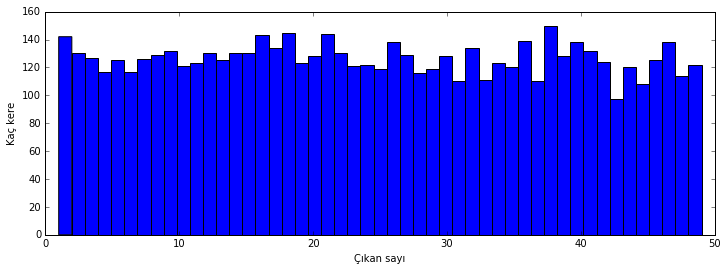

In [23]:
fig = pl.figure(figsize=(12,4))
pl.hist(sayilar, bins=49);
pl.xlabel("Çıkan sayı")
pl.ylabel("Kaç kere");

1-49 arası sayıların sayımları arasında değişkenlik var, ama buna bakarak sayıların olasılıkları farklı diyemeyiz. Eşit olasılık olsa bile, değişkenliğin çeşitli sebepleri olabilir:
* Rastgele süreçlerin doğası.
* Nispeten az sayıda (~6000) kayıt olması.
* Bir çekiliş içinde sayıların çekilme olasılıklarının aynı olmaması. Sayısal Loto'nun her çekilişinde _birbirinden farklı_ altı sayı çekilmelidir. Mesela önce 14 çıktıysa, sonraki beş çekimde 14 çıkmayacaktır. Bu şart, düzgün dağılıma yakınsamayı yavaşlatır.

En çok çıkan on sayı ve kaç kere çıktıkları:

In [29]:
Counter(sayilar).most_common(10)

[(38, 150),
 (18, 145),
 (21, 144),
 (16, 143),
 (1, 142),
 (36, 139),
 (26, 138),
 (40, 138),
 (47, 138),
 (17, 134)]

Bu dağılımlara bakarak Sayısal Loto hileli veya hilesiz demek mümkün mü? Bütün sayıların (1-49) eşit olasılıkta olduğunu varsayarak, buradaki gibi bir değişkenlik ortaya çıkabilir mi? Bu hipotezi test etmek için Pearson ki-kare testini uygulamamız gerekir. Ancak, her bir çekilişte sayıların birbirinden farklı çıkması mecburiyeti sebebiyle bu testin farklı bir versiyonunu uygulamamız gerek.

(Haigh, J. (1997), The Statistics of the National Lottery. Journal of the Royal Statistical Society: Series A (Statistics in Society), 160: 187–206. doi:10.1111/1467-985X.00056)

$W$ istatistiğini aşağıdaki gibi tanımlayalım.

$$ W = \frac{M(M-1)}{(M-m)Dm} \left( \sum_{i=1}^{M} X_i - \frac{m^2 D^2}{M}\right) $$

Burada $M=49$ çekilebilecek sayılar, $m=6$ bir çekilişte kaç top çekildiği, $D$ çekiliş sayısı, $X_i$ $i$ numaralı topun kaç kere çekildiğidir.

In [18]:
M = 49
m = 6
D = len(sayilar)/6
X = [f[1] for f in sorted(Counter(sayilar).most_common())]

W = M*(M-1)/((M-m)*D*m) * (sum([x**2 for x in X]) - m**2 * D**2 / M )
print(W)

46.9436311551217


Bu yeni istatistik $\chi^2_{M-1}$ dağılımına uyar. Böylece hilesizlik hipotezinin p değerini bulabiliriz.

In [19]:
from scipy.stats import chi2
1-chi2.cdf(W,M-1)

0.51610614604308425

Sözlü olarak ifade edersek: Loto çekilişinin hilesiz (yani bütün sayıların eşit olasılıkta düştüğü) varsayımıyla, buradaki kadar veya daha büyük bir değişkenlik gözleme olasılığı %52'dir. Bu olasılık %5 veya daha düşük olsa hilesizlik varsayımını reddedebilirdik, ama bu durumda reddedemiyoruz. Sayısal Loto'da bazı sayıların daha yüksek olasılıklarla çıktığını düşünmek için bir sebep yok.